# Template Based Matching

**ICS3206 - Course Project (Jupyter Notebook #2)**

---

**Name:** Andrea Filiberto Lucas  
**ID No:** 0279704L

---

## Importing Necessary Libraries

Essential libraries such as OpenCV, NumPy, Matplotlib, IPyWidgets, and Pillow are imported in this section. The script checks for these packages and installs any that are missing using `pip`, ensuring the environment is properly configured for the subsequent code cells.

In [ ]:
############################
#         IMPORTS          #
############################

import importlib
import subprocess
import sys

# ANSI escape codes for colored text
GREEN = "\033[92m"
RED = "\033[91m"
RESET = "\033[0m"

# List of packages to check and their corresponding import names
packages = {
    'opencv-python': 'cv2',
    'numpy': 'numpy',
    'matplotlib': 'matplotlib.pyplot',
    'seaborn': 'seaborn',
    'pandas': 'pandas',           
    'ipywidgets': 'ipywidgets',   
    'Pillow': 'PIL',              
}

def install_package(package_name):
    """
    Install a package using pip.
    """
    try:
        print(f"Installing package: {package_name}")
        subprocess.check_call([sys.executable, "-m", "pip", "install", package_name])
        print(f"{GREEN}Successfully installed {package_name}.{RESET}")
    except subprocess.CalledProcessError as e:
        # Print the error message in red
        print(f"{RED}Failed to install package {package_name}. Error: {e}{RESET}")
        sys.exit(1)

def check_and_install_packages(packages_dict):
    """
    Check if the packages are installed, and install them if they are missing.
    """
    for package, import_name in packages_dict.items():
        try:
            # Attempt to import the package
            importlib.import_module(import_name.split('.')[0])
            print(f"{RESET}Package '{package}' is already installed.{RESET}")
        except ImportError:
            print(f"{RED}Package '{package}' is not installed.{RESET}")
            install_package(package)

# Check and install packages
check_and_install_packages(packages)

# Now, import the packages after ensuring they are installed
try:
    import cv2
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    import pandas as pd
    from concurrent.futures import ThreadPoolExecutor, as_completed
    import threading
    import sys
    import os
    import glob
    import ipywidgets as widgets
    from IPython.display import display, clear_output
    from PIL import Image
except ImportError as e:
    print(f"{RED}An error occurred while importing packages: {e}{RESET}")
    sys.exit(1)

# Print the success message in green
print(f"{GREEN}All required packages are installed and imported successfully.{RESET}")


Package 'opencv-python' is already installed.
Package 'numpy' is already installed.
Package 'matplotlib' is already installed.
Package 'seaborn' is already installed.
Package 'pandas' is already installed.
Package 'ipywidgets' is already installed.
Package 'Pillow' is already installed.
All required packages are installed and imported successfully.


## Settings

This section defines the configuration parameters and settings essential for this jupyter notebook. It includes a function to select sky images from a specified directory using an interactive dropdown widget. Additionally, various thresholds and constraints are set for the template matching process, such as the ratio test threshold, minimum number of good matches, scaling factors for templates, and bounding box area limits.

In [ ]:
#############################
#         SETTINGS          #
#############################

def select_sky_image(temp_dir="../Temp/"):
    """
    Display a dropdown widget to select an image from the specified directory.
    """
    import os
    import glob
    import sys
    from IPython.display import display, clear_output
    import ipywidgets as widgets

    # Supported image extensions
    image_extensions = ['*.png', '*.jpg', '*.jpeg', '*.bmp']
    
    # List to hold all found image paths
    image_files = []
    
    # Search for images with supported extensions
    for ext in image_extensions:
        image_files.extend(glob.glob(os.path.join(temp_dir, ext)))
    
    # Filter out non-file paths (just in case)
    image_files = [f for f in image_files if os.path.isfile(f)]
    
    # If no images are found, display an error message
    if not image_files:
        print(f"No images found in the directory '{temp_dir}'. Please add images and try again.")
        sys.exit(1)
    
    # Sort the images alphabetically
    image_files.sort()
    
    # Create a list of image filenames for display
    image_names = [os.path.basename(f) for f in image_files]
    
    # Create a Dropdown widget with increased width and adjusted description width
    dropdown = widgets.Dropdown(
        options=image_names,
        description='Select Image:',
        disabled=False,
        layout=widgets.Layout(width='350px'),  # Increased width for the dropdown
        style={'description_width': '85px'}   # Adjusted description width
    )
    
    # Create an Output widget to display the selected image path
    out = widgets.Output()
    
    # Define the callback function when a selection is made
    def on_change(change):
        """
        Display the selected image path when a new image is selected.
        """
        if change['type'] == 'change' and change['name'] == 'value':
            with out:
                clear_output()
                selected_image = os.path.join(temp_dir, change['new'])
                print(f"Selected image: {selected_image}")
                # Update the global variable
                global sky_image_path
                sky_image_path = selected_image
    
    # Attach the callback to the Dropdown
    dropdown.observe(on_change)
    
    # Display the widgets
    display(dropdown, out)
    
    # Initialize the sky_image_path with the first image and display it in the output widget
    if image_files:
        sky_image_path = image_files[0]
        with out:
            print(f"Default selected image: {sky_image_path}")
    
    return sky_image_path

# Set the sky_image_path dynamically based on user selection
sky_image_path = select_sky_image("../Temp/")  # Updated path for image selection

template_dir = "../8CD/"  # Folder containing sub-folders with constellation templates

# Ratio test threshold for Lowe's test (stricter => 0.6 to 0.7)
RATIO_TEST_THRESH = 0.7

# Minimum number of good matches
MIN_GOOD_MATCHES = 15

# Scales to try for each template
SCALES = [0.6, 0.8, 0.9, 1.0, 1.1, 1.2, 1.3, 1.4]

# Bounding box area constraints (to discard wildly incorrect homographies)
MIN_BBOX_AREA = 100   # e.g., discard if warped area < 100 pixels
MAX_BBOX_AREA = 1e7   # e.g., discard if warped area > 10 million pixels

Dropdown(description='Select Image:', layout=Layout(width='350px'), options=('1-CB.png', '1-LAC.png', '1-LM.pn…

Output()

## Global Progress

This section manages the tracking of the overall progress during template processing. The total number of templates is calculated by scanning all relevant directories, and a shared counter is initialized to monitor the number of processed templates. A thread-safe mechanism is implemented to update and display a dynamic progress bar, providing real-time feedback on the percentage of completion. This ensures efficient monitoring of the processing workflow and helps maintain transparency throughout the project's execution.

### What is Shoelace Formula?
The Shoelace Formula is a mathematical method for calculating the area of a polygon by using the coordinates of its vertices. It involves multiplying and summing the coordinates in a specific pattern that resembles shoelace lacing.

In [24]:
#############################
#     GLOBAL PROGRESS       #
#############################

# Calculate the total number of templates (files) across all subfolders
all_template_files = []
for folder in os.listdir(template_dir):
    folder_path = os.path.join(template_dir, folder)
    if os.path.isdir(folder_path):
        for f in os.listdir(folder_path):
            if not f.startswith("."):  # ignore hidden files
                full_path = os.path.join(folder_path, f)
                all_template_files.append((folder, full_path))

total_templates = len(all_template_files)
progress_lock = threading.Lock()
templates_processed = 0  # shared counter

def update_progress():
    """
    Safely update the global progress and print a single progress bar
    showing how many templates have been processed out of the total.
    """
    with progress_lock:
        global templates_processed
        templates_processed += 1
        percentage = (templates_processed / total_templates) * 100
        bar = create_progress_bar(percentage)
        sys.stdout.write(f"\rProcessing Templates: {percentage:5.1f}% {bar} ({templates_processed}/{total_templates})")
        sys.stdout.flush()

#############################
#       HELPER METHODS      #
#############################

def load_image(image_path):
    """Load an image from the given path and convert it to grayscale."""
    if not os.path.exists(image_path):
        print(f"[ERROR] File does not exist: {image_path}")
        return None
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"[ERROR] Could not load image at {image_path}")
    return image

def preprocess_image(image):
    """Apply histogram equalization if contrast is low."""
    if image is None:
        return None
    if cv2.meanStdDev(image)[1] < 50:
        return cv2.equalizeHist(image)
    return image

def display_image(image, title="Image"):
    """Display an image (grayscale) via matplotlib."""
    plt.figure(figsize=(10, 8))
    plt.imshow(image, cmap='gray')
    plt.title(title)
    plt.axis('off')
    plt.show()

def create_progress_bar(percentage, width=50):
    """Generate a simple text-based progress bar."""
    filled = int(width * percentage / 100) if percentage else 0
    return "█" * filled + "░" * (width - filled)

def polygon_area(corners):
    """
    Compute the polygon area using the Shoelace formula.
    corners should be a list or array of shape (4, 2).
    """
    x = corners[:, 0]
    y = corners[:, 1]
    # Shoelace formula
    return 0.5 * np.abs(np.dot(x, np.roll(y, 1)) - np.dot(y, np.roll(x, 1)))

## Main Matching Logic

This section implements the core functionality for matching constellation templates with the sky image (previously selected image). The sky image is loaded and preprocessed, and the ORB feature detector is initialized to identify keypoints and descriptors. For each template, multiple scales are applied to account for size variations, and keypoints are matched using a FLANN-based matcher with Lowe's ratio test to ensure robust correspondences. Homography is computed using RANSAC to filter out outliers, and bounding box area constraints are enforced to validate the matches. A scoring mechanism evaluates the quality of each match, and progress is updated in real-time to monitor the matching process efficiently.

### What is ORB Features?

ORB (Oriented FAST and Rotated BRIEF) is a feature detection and description algorithm used to identify and describe keypoints in images. It is efficient and robust, making it suitable for real-time applications. ORB combines the FAST keypoint detector and the BRIEF descriptor with additional modifications to handle rotation and improve performance.

### What is a FLANN-based Matcher with Lowe's Ratio?

FLANN (Fast Library for Approximate Nearest Neighbors) is an optimized library for fast nearest neighbor searches in large datasets. When combined with Lowe's ratio test, it efficiently matches feature descriptors by finding the two nearest neighbors for each descriptor and accepting the match only if the distance of the closest neighbor is significantly lower than the second closest. This helps in reducing false matches and improving matching accuracy.

### What is Homography and RANSAC?

Homography is a transformation matrix that maps points from one plane to another, allowing for the alignment of images taken from different perspectives. RANSAC (Random Sample Consensus) is an iterative algorithm used to estimate the homography by identifying inliers among the matched keypoints, thereby filtering out outliers. Together, they enable the accurate alignment and matching of features between images despite noise and mismatches.

In [25]:
#############################
#     MAIN MATCHING LOGIC   #
#############################

# Load the sky image once
sky_image = load_image(sky_image_path)
if sky_image is None:
    print("[FATAL] Sky image not found or could not be loaded.")
    sys.exit(1)

sky_image = preprocess_image(sky_image)
sky_h, sky_w = sky_image.shape

# Initialize ORB
orb = cv2.ORB_create(nfeatures=2000)

def match_keypoints(template_img, sky_img):
    """
    1. Detect and compute ORB features for both images.
    2. Use FLANN-based matcher and Lowe's ratio test.
    3. Use RANSAC to filter out outliers and compute homography.
    4. Discard matches if bounding box is out of realistic area range.
    Returns:
        kp1, kp2, good_matches, mean_dist, homography
    """
    kp1, des1 = orb.detectAndCompute(template_img, None)
    kp2, des2 = orb.detectAndCompute(sky_img, None)

    if des1 is None or des2 is None:
        return kp1, kp2, [], None, None

    # Convert to float32 if needed
    if des1.dtype != np.float32:
        des1 = des1.astype(np.float32)
    if des2.dtype != np.float32:
        des2 = des2.astype(np.float32)

    # FLANN for ORB (LSH Index)
    index_params = dict(algorithm=1, trees=10)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    # KNN match
    matches = flann.knnMatch(des1, des2, k=2)

    # Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < RATIO_TEST_THRESH * n.distance:
            good_matches.append(m)

    # If enough matches, try homography
    M = None
    mean_dist = None
    if len(good_matches) >= MIN_GOOD_MATCHES:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        if M is not None and mask is not None:
            # Keep only inliers
            mask = mask.ravel().astype(bool)
            inlier_matches = [good_matches[i] for i, val in enumerate(mask) if val]
            good_matches = inlier_matches

            # Compute average distance of inlier matches
            distances = [m.distance for m in good_matches]
            mean_dist = float(np.mean(distances)) if distances else None

            # Optional bounding-box check
            h_t, w_t = template_img.shape
            corners = np.float32([[0, 0],
                                  [w_t, 0],
                                  [w_t, h_t],
                                  [0,   h_t]]).reshape(-1, 1, 2)

            # Warp the template's corners onto the sky
            warped_corners = cv2.perspectiveTransform(corners, M)
            warped_corners = warped_corners.reshape(-1, 2)

            # Calculate area
            area = polygon_area(warped_corners)
            # If area is out of plausible range, discard these matches
            if not (MIN_BBOX_AREA <= area <= MAX_BBOX_AREA):
                good_matches = []
                M = None

    return kp1, kp2, good_matches, mean_dist, M

def resize_template(template, scale_factor):
    """Resize template by the given scale factor."""
    new_w = int(template.shape[1] * scale_factor)
    new_h = int(template.shape[0] * scale_factor)
    return cv2.resize(template, (new_w, new_h))

def compute_match_score(num_good_matches, mean_dist):
    """
    Example scoring function:
      score = num_good_matches / (mean_dist + 1)
    The lower the mean distance, the higher the score.
    The more good matches, the higher the score.
    """
    if mean_dist is None:  # If no distance is computed, score = 0
        return 0.0
    return float(num_good_matches) / (mean_dist + 1.0)

def process_single_template(folder_name, template_path):
    """
    Load a single template, preprocess it, try multiple scales,
    pick the best scale's match among them, and return result.
    """
    best_result = None  # Stores: (score, num_good_matches, scale, template_img, kp1, kp2, matches, matched_vis)
    template_img = load_image(template_path)
    if template_img is None:
        return None
    template_img = preprocess_image(template_img)

    # Iterate over multiple scales
    for scale in SCALES:
        resized = resize_template(template_img, scale)
        kp1, kp2, g_matches, mean_dist, M = match_keypoints(resized, sky_image)

        if g_matches:
            num_good = len(g_matches)
            current_score = compute_match_score(num_good, mean_dist)
            if (best_result is None) or (current_score > best_result[0]):
                # Draw a quick visualization for potential final use
                matched_vis = None
                if kp1 and kp2 and g_matches:
                    matched_vis = cv2.drawMatches(
                        resized, kp1, sky_image, kp2, g_matches, None,
                        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
                    )
                best_result = (
                    current_score,
                    num_good,
                    scale,
                    folder_name,
                    os.path.basename(template_path),
                    matched_vis
                )

    update_progress()
    return best_result

## Gather & Process Data

In this section, template matching results are gathered and processed efficiently. The total number of template files is determined, and a `ThreadPoolExecutor` is utilized to concurrently process each template. Each template is analyzed individually, and the outcomes are collected into a results list. Once all templates have been processed, the results are sorted in descending order based on their matching scores, preparing the data for the selection of the top matches.

Found 80 total template files to process in '../8CD/'.
Processing Templates: 100.0% ██████████████████████████████████████████████████ (80/80)

Finished Processing

Rank 1: Constellation: CoronaBorealis | Template: CoronaBorealis-AbsoluteClean.png
  Scale: 1.0 | Good Matches: 451 | Score: 451.00
  Approx Probability: 0.0779%



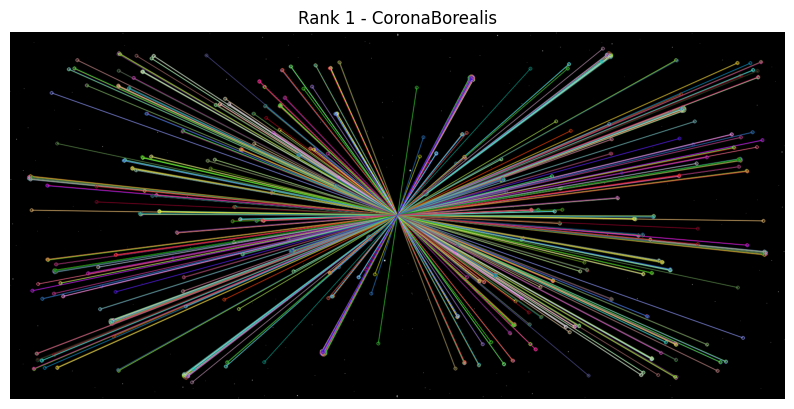

Rank 2: Constellation: Sextans | Template: Sextans-APPCleanup.jpg
  Scale: 1.2 | Good Matches: 33 | Score: 1.13
  Approx Probability: 0.0057%



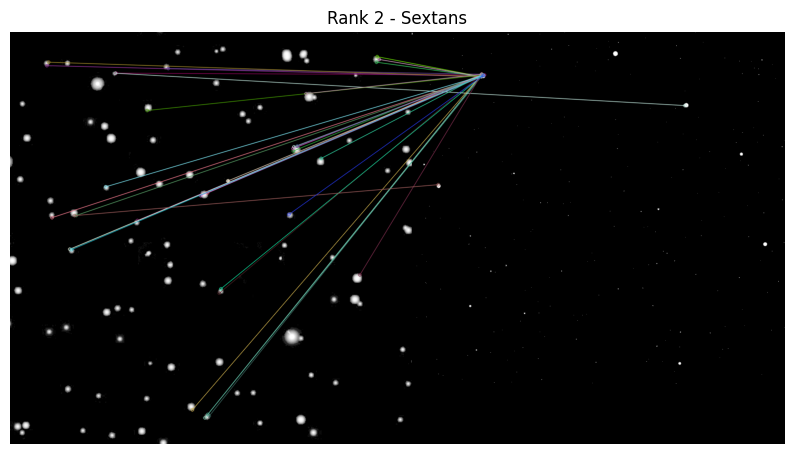

Rank 3: Constellation: Lacerta | Template: Lacerta-LightSky.png
  Scale: 0.9 | Good Matches: 16 | Score: 0.75
  Approx Probability: 0.0028%



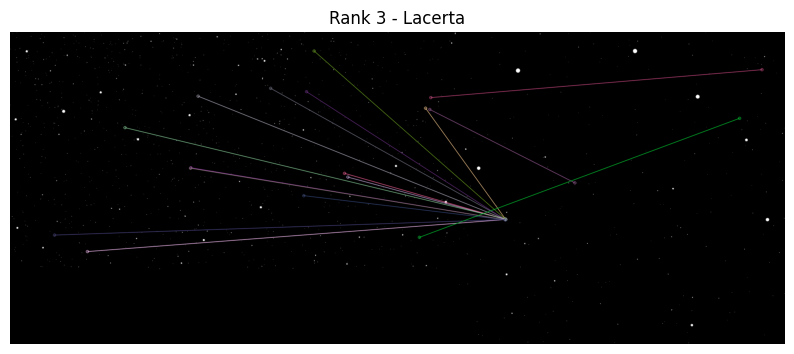

In [ ]:
#############################
#   GATHER & PROCESS DATA   #
#############################

# Prepare to gather match results
results = []

def worker(args):
    """Helper function for concurrency: process a single template."""
    folder_name, template_path = args
    return process_single_template(folder_name, template_path)

print(f"Found {total_templates} total template files to process in '{template_dir}'.")

# Use a ThreadPoolExecutor to process each template concurrently
with ThreadPoolExecutor() as executor:
    futures = [executor.submit(worker, tpl) for tpl in all_template_files]
    for fut in as_completed(futures):
        outcome = fut.result()
        if outcome is not None:
            results.append(outcome)

# Normalize folder names (e.g., treat "CoronaBorealis" and "CoronaBorealis_augmented" as the same)
def normalize_folder_name(folder_name):
    """
    Normalize the folder name by removing '_augmented' suffix or any other distinction.
    """
    return folder_name.split("_")[0]  # Keep only the base name before any underscores

# Sort by the final computed score in descending order
# Each result is (score, num_good, scale, folder_name, template_filename, matched_vis)
results.sort(key=lambda x: x[0], reverse=True)

#############################
#   SELECT & PRINT TOP 3    #
#############################

# Pick the top result from each constellation folder (3 unique constellations)
seen_folders = set()
top_3 = []

for res in results:
    score, num_good, scale, folder, tpl_file, matched_vis = res
    normalized_folder = normalize_folder_name(folder)
    if normalized_folder not in seen_folders:
        seen_folders.add(normalized_folder)
        top_3.append(res)
        if len(top_3) == 3:
            break

print("\n\n\033[1mFinished Processing\033[0m\n")

# Display the top 3 matches
for rank, (score, num_good, scale, folder, tpl_file, matched_vis) in enumerate(top_3, start=1):
    probability = (num_good / float(sky_h * sky_w)) * 100

    print(f"Rank {rank}: Constellation: {normalize_folder_name(folder)} | Template: {tpl_file}")
    print(f"  Scale: {scale} | Good Matches: {num_good} | Score: {score:.2f}")
    print(f"  Approx Probability: {probability:.4f}%\n")

    if matched_vis is not None:
        display_image(matched_vis, title=f"Rank {rank} - {normalize_folder_name(folder)}")

## Results Summary & Visualization

This section compiles and visualizes the results of the template matching process. A summary table of the top three constellation matches is created and displayed using a pandas DataFrame. Additionally, bar charts are generated with Seaborn to illustrate the matching scores of the top matches and the average scores per constellation. These visualizations provide a clear and comprehensive overview of the matching performance, facilitating easy comparison and analysis of the results.

Top 3 Constellation Matches:


,Rank,Constellation,Template File,Scale Factor,Good Matches,Score,Approx Probability (%)
0,1,CoronaBorealis,CoronaBorealis-AbsoluteClean.png,1.0,451,451.00,0.0779
1,2,Sextans,Sextans-APPCleanup.jpg,1.2,33,1.13,0.0057
2,3,Lacerta,Lacerta-LightSky.png,0.9,16,0.75,0.0028


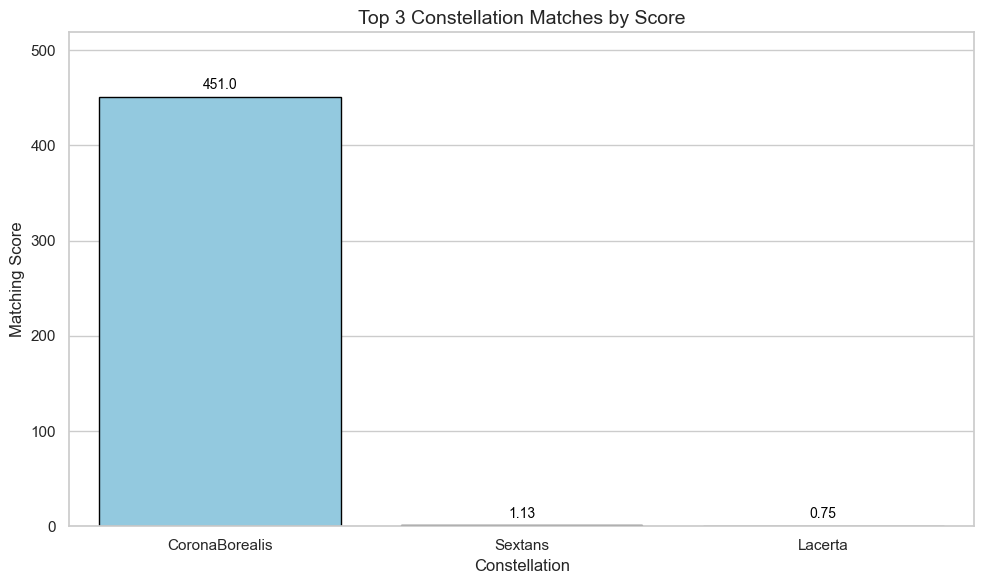

Average Matching Scores per Constellation:


,Constellation,Average Score
0,CoronaBorealis,56.601667
6,Sextans,0.368721
2,LeoMinor,0.238940
1,Lacerta,0.176284
7,Virgo,0.116457
5,Pisces,0.073025
4,Norma,0.057954
3,Lepus,0.055386


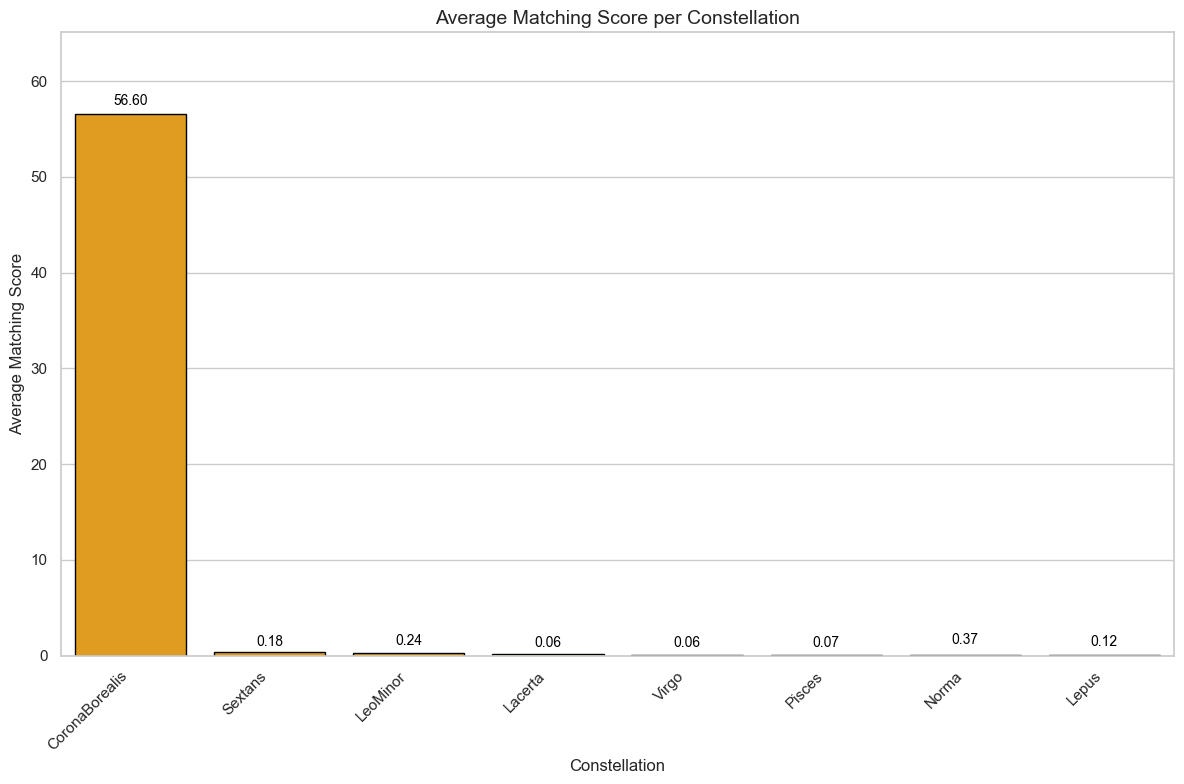

In [ ]:
######################################
#   RESULTS SUMMARY & VISUALIZATION  #
######################################

summary_data = [
    {
        'Rank': rank,
        'Constellation': folder,
        'Template File': tpl_file,
        'Scale Factor': scale,
        'Good Matches': num_good,
        'Score': round(score, 2),
        'Approx Probability (%)': round((num_good / (sky_h * sky_w)) * 100, 4)
    }
    for rank, (score, num_good, scale, folder, tpl_file, matched_vis) in enumerate(top_3, start=1)
]

# Create DataFrame
summary_df = pd.DataFrame(summary_data)

# Display the summary table
print("Top 3 Constellation Matches:")
display(summary_df)

# Visualization settings
sns.set(style="whitegrid")

# Plot Top 3 Constellation Scores
plt.figure(figsize=(10, 6))
barplot = sns.barplot(
    x='Constellation',
    y='Score',
    data=summary_df,
    color='skyblue',  # Changed from palette to color
    edgecolor='black'
)

# Add value labels on top of each bar
for index, row in summary_df.iterrows():
    barplot.text(
        index,
        row['Score'] + summary_df['Score'].max() * 0.01,
        f"{row['Score']}",
        color='black',
        ha="center",
        va='bottom',
        fontsize=10
    )

plt.xlabel('Constellation', fontsize=12)
plt.ylabel('Matching Score', fontsize=12)
plt.title('Top 3 Constellation Matches by Score', fontsize=14)
plt.ylim(0, summary_df['Score'].max() * 1.15)  # Add space above the highest bar
plt.tight_layout()
plt.show()

# Calculate Average Scores per Constellation using pandas
results_df = pd.DataFrame(results, columns=['Score', 'Num_Good', 'Scale', 'Constellation', 'Template_File', 'Matched_Vis'])
avg_scores_df = results_df.groupby('Constellation')['Score'].mean().reset_index()
avg_scores_df.rename(columns={'Score': 'Average Score'}, inplace=True)
avg_scores_df.sort_values(by='Average Score', ascending=False, inplace=True)

# Display the average scores table
print("Average Matching Scores per Constellation:")
display(avg_scores_df)

# Plot Average Matching Scores per Constellation
plt.figure(figsize=(12, 8))
barplot_avg = sns.barplot(
    x='Constellation',
    y='Average Score',
    data=avg_scores_df,
    color='orange',  # Changed from palette to color
    edgecolor='black'
)

# Add value labels on top of each bar
for index, row in avg_scores_df.iterrows():
    barplot_avg.text(
        index,
        row['Average Score'] + avg_scores_df['Average Score'].max() * 0.01,
        f"{row['Average Score']:.2f}",
        color='black',
        ha="center",
        va='bottom',
        fontsize=10
    )

plt.xlabel('Constellation', fontsize=12)
plt.ylabel('Average Matching Score', fontsize=12)
plt.title('Average Matching Score per Constellation', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.ylim(0, avg_scores_df['Average Score'].max() * 1.15)  # Add space above the highest bar
plt.tight_layout()
plt.show()

In [1]:
# To REMOVE: Temporary directory for testing
test_image_dir = "../Temp/"
ground_truth = {
    "1-CB.png":  "CoronaBorealis",
    "1-LAC.png": "Lacerta",
    "1-LM.png":  "LeoMinor",
    "1-LPS.png": "Lepus",
    "1-P.png":   "Pisces",
    "1-V.png":   "Virgo",
    "1-S.png":   "Sextans",
    "1-N.png":   "Norma",
}